In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean
from datetime import datetime

### SARS-CoV-2 Variants

In [3]:
id_col = "accession_id"
file_paths = {
    "ProtT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250201/uniref90/external/prot_t5_xl_uniref50_lr3e-4.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250201/uniref90/external/prostt5_lr3e-4.csv"),
    #"ESM2-35M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm2_t12_35M_UR50D_lr1e-4.csv"),
    #"ESM2-650M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm2_t33_650M_UR50D_lr1e-4.csv"),
    "ESM2-3B": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm2_t36_3B_UR50D_lr1e-4.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64.csv")
}

In [4]:
dfs = []
for k, v in file_paths.items():
    df = pd.read_csv(v)
    df["model"] = k
    dfs.append(df)
df = pd.concat(dfs)
df

,accession_id,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,y_true,pangolin_lineage,geo_location,seq_length,model
0,UDW43218.1,0.006330,1.050447e-02,0.006680,0.032874,0.005100,0.019163,0.909526,0.009823,Human,C.37,USA: Texas,1266,ProtT5
1,UJZ71565.1,0.008074,2.483119e-07,0.000002,0.911808,0.033276,0.006743,0.028032,0.012065,Human,B.1.1.529,USA,1273,ProtT5
2,UES70215.1,0.003342,1.227013e-03,0.795080,0.015439,0.004009,0.139110,0.039315,0.002477,Human,B.1.526,USA,1273,ProtT5
3,QSE06394.1,0.003247,1.127909e-03,0.806335,0.014812,0.003732,0.130946,0.037447,0.002354,Human,P.2,USA: California,1273,ProtT5
4,QTN76737.1,0.003458,1.174976e-03,0.801658,0.015148,0.003921,0.133582,0.038618,0.002440,Human,P.2,USA: New Jersey,1273,ProtT5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,QVL01758.1,0.040101,4.819087e-06,0.614859,0.024371,0.003751,0.032906,0.273032,0.010976,Human,B.1.1.7,USA: Michigan,1270,VirProBERT
1522,QVG32451.1,0.024636,5.279566e-06,0.142835,0.015277,0.003411,0.029747,0.768989,0.015099,Human,B.1.617.1,USA: Illinois,1273,VirProBERT
1523,UIT75201.1,0.008459,1.363562e-06,0.070926,0.010776,0.001566,0.009238,0.889716,0.009317,Human,B.1.427,USA,1273,VirProBERT
1524,UGW14958.1,0.021574,8.265451e-06,0.166947,0.015973,0.003626,0.032665,0.739008,0.020199,Human,B.1.427,USA,1273,VirProBERT


##### Process ESM3 separately because it was executed using the pertubation analysis pipeline and not the sarscov2 variant pipeline.

In [5]:
esm3_df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm3_lr1e-4.csv"))
esm3_df["model"] = "ESM3"
esm3_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,accession_id,y_true,model
0,0.013420,0.000370,0.246287,0.021458,0.009859,0.079028,0.613571,0.016007,QUR40592.1,Human,ESM3
1,0.002790,0.000780,0.748513,0.008765,0.003287,0.196386,0.029051,0.010427,UCK71595.1,Human,ESM3
2,0.002410,0.000846,0.748511,0.007380,0.003473,0.199265,0.028266,0.009849,UEA15086.1,Human,ESM3
3,0.015028,0.000223,0.074244,0.022930,0.016191,0.053944,0.808746,0.008695,QVN41227.1,Human,ESM3
4,0.002948,0.000823,0.706261,0.009218,0.003386,0.236314,0.029563,0.011487,QYZ52400.1,Human,ESM3
...,...,...,...,...,...,...,...,...,...,...,...
1521,0.033002,0.003407,0.076918,0.020166,0.010857,0.016620,0.824890,0.014139,QUI11057.1,Human,ESM3
1522,0.002282,0.000688,0.766168,0.007731,0.002871,0.182816,0.027462,0.009982,QVE76837.1,Human,ESM3
1523,0.002649,0.000806,0.774727,0.008059,0.003375,0.171108,0.028715,0.010560,QTS06228.1,Human,ESM3
1524,0.008682,0.000308,0.506420,0.020655,0.019005,0.082999,0.341344,0.020586,UIT31286.1,Human,ESM3


In [6]:
# get the mapping between accession ids and the pangolin lineage
accession_id_pangolin_lineage_map = df[df["model"] == "VirProBERT"][["accession_id", "pangolin_lineage"]].set_index("accession_id").to_dict()["pangolin_lineage"]
accession_id_pangolin_lineage_map

{'UDK53098.1': 'B',
 'QVK76058.1': 'B.1.526',
 'URA56840.1': 'P.1',
 'UQM96776.1': 'BA.1',
 'QUA30248.1': 'B.1.525',
 'QZK79290.1': 'B.1.351',
 'QVD98248.1': 'B.1.617.1',
 'QVD69993.1': 'B.1.429',
 'QTW74521.1': 'B.1.525',
 'UEL67414.1': 'B.1.621',
 'QVF96340.1': 'B.1.351',
 'WFH55996.1': 'BA.1',
 'UBO11583.1': 'B.1.351',
 'QTK18242.1': 'P.2',
 'WBO26260.1': 'B.1.617.1',
 'URA68735.1': 'P.1',
 'UBA51659.1': 'B.1.617.2',
 'QWO25606.1': 'P.3',
 'QUQ12133.1': 'C.37',
 'QVJ23267.1': 'P.2',
 'UJE57960.1': 'BA.1',
 'QTC70831.1': 'B.1.429',
 'ULL32145.1': 'B.1.351',
 'UFR25064.1': 'B.1.1.7',
 'QWX81175.1': 'B.1.429',
 'QSM31389.1': 'B.1.427',
 'QVO64483.1': 'B.1.1.7',
 'QWA59502.1': 'B.1.1.7',
 'QTD26339.1': 'P.2',
 'QVE77712.1': 'B.1.617.1',
 'UJI25917.1': 'B.1.1.529',
 'QTY51616.1': 'B.1.351',
 'UGN57134.1': 'B.1.617.2',
 'QTM57140.1': 'B.1.427',
 'UDG39849.1': 'B.1.617.2',
 'UBE75120.1': 'B.1.621',
 'QWB70853.1': 'B.1.617.1',
 'UIC12071.1': 'B.1.429',
 'UJJ02771.1': 'BA.1',
 'QUM46224.1': 

In [7]:
esm3_df["pangolin_lineage"] = esm3_df.apply(lambda x: accession_id_pangolin_lineage_map[x["accession_id"]], axis=1)
esm3_df.shape

(1526, 12)

In [8]:
df = pd.concat([df, esm3_df])

In [9]:
df["model"].value_counts()

model
ProtT5        1526
ProstT5       1526
ESM2-3B       1526
VirProBERT    1526
ESM3          1526
Name: count, dtype: int64

In [10]:
order = list(df["pangolin_lineage"].sort_values().unique())
order.remove("B")
order = ["B"] + order
order

['B',
 'B.1.1.529',
 'B.1.1.7',
 'B.1.351',
 'B.1.427',
 'B.1.429',
 'B.1.525',
 'B.1.526',
 'B.1.617.1',
 'B.1.617.2',
 'B.1.621',
 'BA.1',
 'C.37',
 'P.1',
 'P.2',
 'P.3']

In [23]:
models = list(df["model"].unique())
models = ['ProtT5', 'ProstT5', 'ESM2-3B', 'VirProBERT']
models

['ProtT5', 'ProstT5', 'ESM2-3B', 'VirProBERT']

In [12]:
who_designation_df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "..", "input/data/coronaviridae/20240313/sarscov2/sarscov2_who_designated_voc.csv"))
who_designation_df

,pango_lineage,who_variant,designation,first_designation_date,location
0,B,Wuhan-Hu-1,Index,12/01/2019,China
1,B.1.1.7,Alpha,VOC,12/08/2020,United Kingdom
2,B.1.351,Beta,VOC,12/18/2020,South Africa
3,P.1,Gamma,VOC,1/11/2021,Brazil
4,B.1.617.2,Delta,VOC,5/11/2021,India
5,B.1.427,Epsilon,VOI,3/5/2021,USA
6,B.1.429,Epsilon,VOI,3/5/2021,USA
7,P.2,Zeta,VOI,3/17/2021,Brazil
8,B.1.525,Eta,VOI,3/17/2021,Nigeria
9,P.3,Theta,VOI,3/24/2021,Philippines


In [13]:
who_designation_df["pango_who_annotation"] = who_designation_df["pango_lineage"] + " (" + who_designation_df["who_variant"] + ")" 
variant_order = who_designation_df["pango_who_annotation"].unique()
variant_order

array(['B (Wuhan-Hu-1)', 'B.1.1.7 (Alpha)', 'B.1.351 (Beta)',
       'P.1 (Gamma)', 'B.1.617.2 (Delta)', 'B.1.427 (Epsilon)',
       'B.1.429 (Epsilon)', 'P.2 (Zeta)', 'B.1.525 (Eta)', 'P.3 (Theta)',
       'B.1.526 (Iota)', 'B.1.617.1 (Kappa)', 'C.37 (Lambda)',
       'B.1.621 (Mu)', 'B.1.1.529 (Omicron)', 'BA.1 (Omicron)'],
      dtype=object)

In [14]:
who_designation_df.rename(columns={"pango_lineage": "pangolin_lineage"}, inplace=True)

In [15]:
df = pd.merge(df, who_designation_df, how="inner", on="pangolin_lineage").drop(columns=["geo_location", "seq_length", "designation", "location"])

In [16]:
df

,accession_id,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,y_true,pangolin_lineage,model,who_variant,first_designation_date,pango_who_annotation
0,UDW43218.1,0.006330,1.050447e-02,0.006680,0.032874,0.005100,0.019163,0.909526,0.009823,Human,C.37,ProtT5,Lambda,6/14/2021,C.37 (Lambda)
1,UJZ71565.1,0.008074,2.483119e-07,0.000002,0.911808,0.033276,0.006743,0.028032,0.012065,Human,B.1.1.529,ProtT5,Omicron,11/26/2021,B.1.1.529 (Omicron)
2,UES70215.1,0.003342,1.227013e-03,0.795080,0.015439,0.004009,0.139110,0.039315,0.002477,Human,B.1.526,ProtT5,Iota,3/24/2021,B.1.526 (Iota)
3,QSE06394.1,0.003247,1.127909e-03,0.806335,0.014812,0.003732,0.130946,0.037447,0.002354,Human,P.2,ProtT5,Zeta,3/17/2021,P.2 (Zeta)
4,QTN76737.1,0.003458,1.174976e-03,0.801658,0.015148,0.003921,0.133582,0.038618,0.002440,Human,P.2,ProtT5,Zeta,3/17/2021,P.2 (Zeta)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7625,QUI11057.1,0.033002,3.407135e-03,0.076918,0.020166,0.010857,0.016620,0.824890,0.014139,Human,B.1.526,ESM3,Iota,3/24/2021,B.1.526 (Iota)
7626,QVE76837.1,0.002282,6.879618e-04,0.766168,0.007731,0.002871,0.182816,0.027462,0.009982,Human,B.1.525,ESM3,Eta,3/17/2021,B.1.525 (Eta)
7627,QTS06228.1,0.002649,8.060397e-04,0.774727,0.008059,0.003375,0.171108,0.028715,0.010560,Human,B.1.427,ESM3,Epsilon,3/5/2021,B.1.427 (Epsilon)
7628,UIT31286.1,0.008682,3.081843e-04,0.506420,0.020655,0.019005,0.082999,0.341344,0.020586,Human,P.2,ESM3,Zeta,3/17/2021,P.2 (Zeta)


### BtHKU5-CoV-2

In [17]:
id_col = "accession_id"
file_paths = {
    "ProtT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/BtHKU5CoV2/20250303/uniref90/external/prot_t5_xl_uniref50_lr3e-4.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/BtHKU5CoV2/20250303/uniref90/external/prostt5_lr3e-4.csv"),
    #"ESM2-35M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm2_t12_35M_UR50D_lr1e-4.csv"),
    #"ESM2-650M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/sarscov2_s_prot_variants/20250123/uniref90/external/esm2_t33_650M_UR50D_lr1e-4.csv"),
    "ESM2-3B": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/BtHKU5CoV2/20250303/uniref90/external/esm2_t36_3B_UR50D_lr1e-4.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/BtHKU5CoV2/20250303/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64.csv")
}

In [20]:
bthku5cov2_dfs = []
for k, v in file_paths.items():
    x_df = pd.read_csv(v, converters={"who_variant": str})
    x_df["model"] = k
    bthku5cov2_dfs.append(x_df)
bthku5cov2_df = pd.concat(bthku5cov2_dfs)
bthku5cov2_df["pango_who_annotation"] = bthku5cov2_df["pango_lineage"] + " (" + bthku5cov2_df["who_variant"] + ")" 
bthku5cov2_df = bthku5cov2_df.rename(columns={"pango_lineage": "pangolin_lineage"}).drop(columns=["protein"])

In [26]:
df = pd.concat([df, bthku5cov2_df])

In [34]:
variant_order_combined = list(variant_order) + list(bthku5cov2_df["pango_who_annotation"].unique())
variant_order_combined

['B (Wuhan-Hu-1)',
 'B.1.1.7 (Alpha)',
 'B.1.351 (Beta)',
 'P.1 (Gamma)',
 'B.1.617.2 (Delta)',
 'B.1.427 (Epsilon)',
 'B.1.429 (Epsilon)',
 'P.2 (Zeta)',
 'B.1.525 (Eta)',
 'P.3 (Theta)',
 'B.1.526 (Iota)',
 'B.1.617.1 (Kappa)',
 'C.37 (Lambda)',
 'B.1.621 (Mu)',
 'B.1.1.529 (Omicron)',
 'BA.1 (Omicron)',
 'BtHKU5-CoV-2 (153)',
 'BtHKU5-CoV-2 (23)',
 'BtHKU5-CoV-2 (28)',
 'BtHKU5-CoV-2 (381)',
 'BtHKU5-CoV-2 (155)',
 'BtHKU5-CoV-2 (441)']

In [27]:
def get_annotation(x):
    mean_val = np.mean(x)
    std_val = np.std(x)
    return "{:.2f}".format(mean_val) + "\n" + u"\u00B1" + "{:.2f}".format(std_val)
    
def get_annotation_df(heatmap_df, model_df):
    annot_df = pd.DataFrame(0, index=heatmap_df.index, columns=heatmap_df.columns)
    annot_idx = heatmap_df.idxmax(axis=1).reset_index()
    mean_std_df = model_df.groupby("pango_who_annotation").agg(lambda x: get_annotation(x))
    for item in annot_idx.values:
        annot_df.loc[item[0], item[1]] = mean_std_df.loc[item[0], item[1]]
        annot_df.loc[item[0], "Human"] = mean_std_df.loc[item[0], "Human"]
    annot_df = annot_df.astype(str)
    annot_df[annot_df == "0"] = ""
    return annot_df

model = (1532, 8)


/tmp/ipykernel_3752096/3754021456.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.52
±0.26' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], item[1]] = mean_std_df.loc[item[0], item[1]]
/tmp/ipykernel_3752096/3754021456.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29
±0.26' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], "Human"] = mean_std_df.loc[item[0], "Human"]
/tmp/ipykernel_3752096/3754021456.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33
±0.22' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], item[1]] = mean_std_df.loc[item

model = (1532, 8)
model = (1532, 8)


/tmp/ipykernel_3752096/3754021456.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.76
±0.28' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], item[1]] = mean_std_df.loc[item[0], item[1]]
/tmp/ipykernel_3752096/3754021456.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13
±0.19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], "Human"] = mean_std_df.loc[item[0], "Human"]
/tmp/ipykernel_3752096/3754021456.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.87
±0.09' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annot_df.loc[item[0], item[1]] = mean_std_df.loc[item

model = (1532, 8)


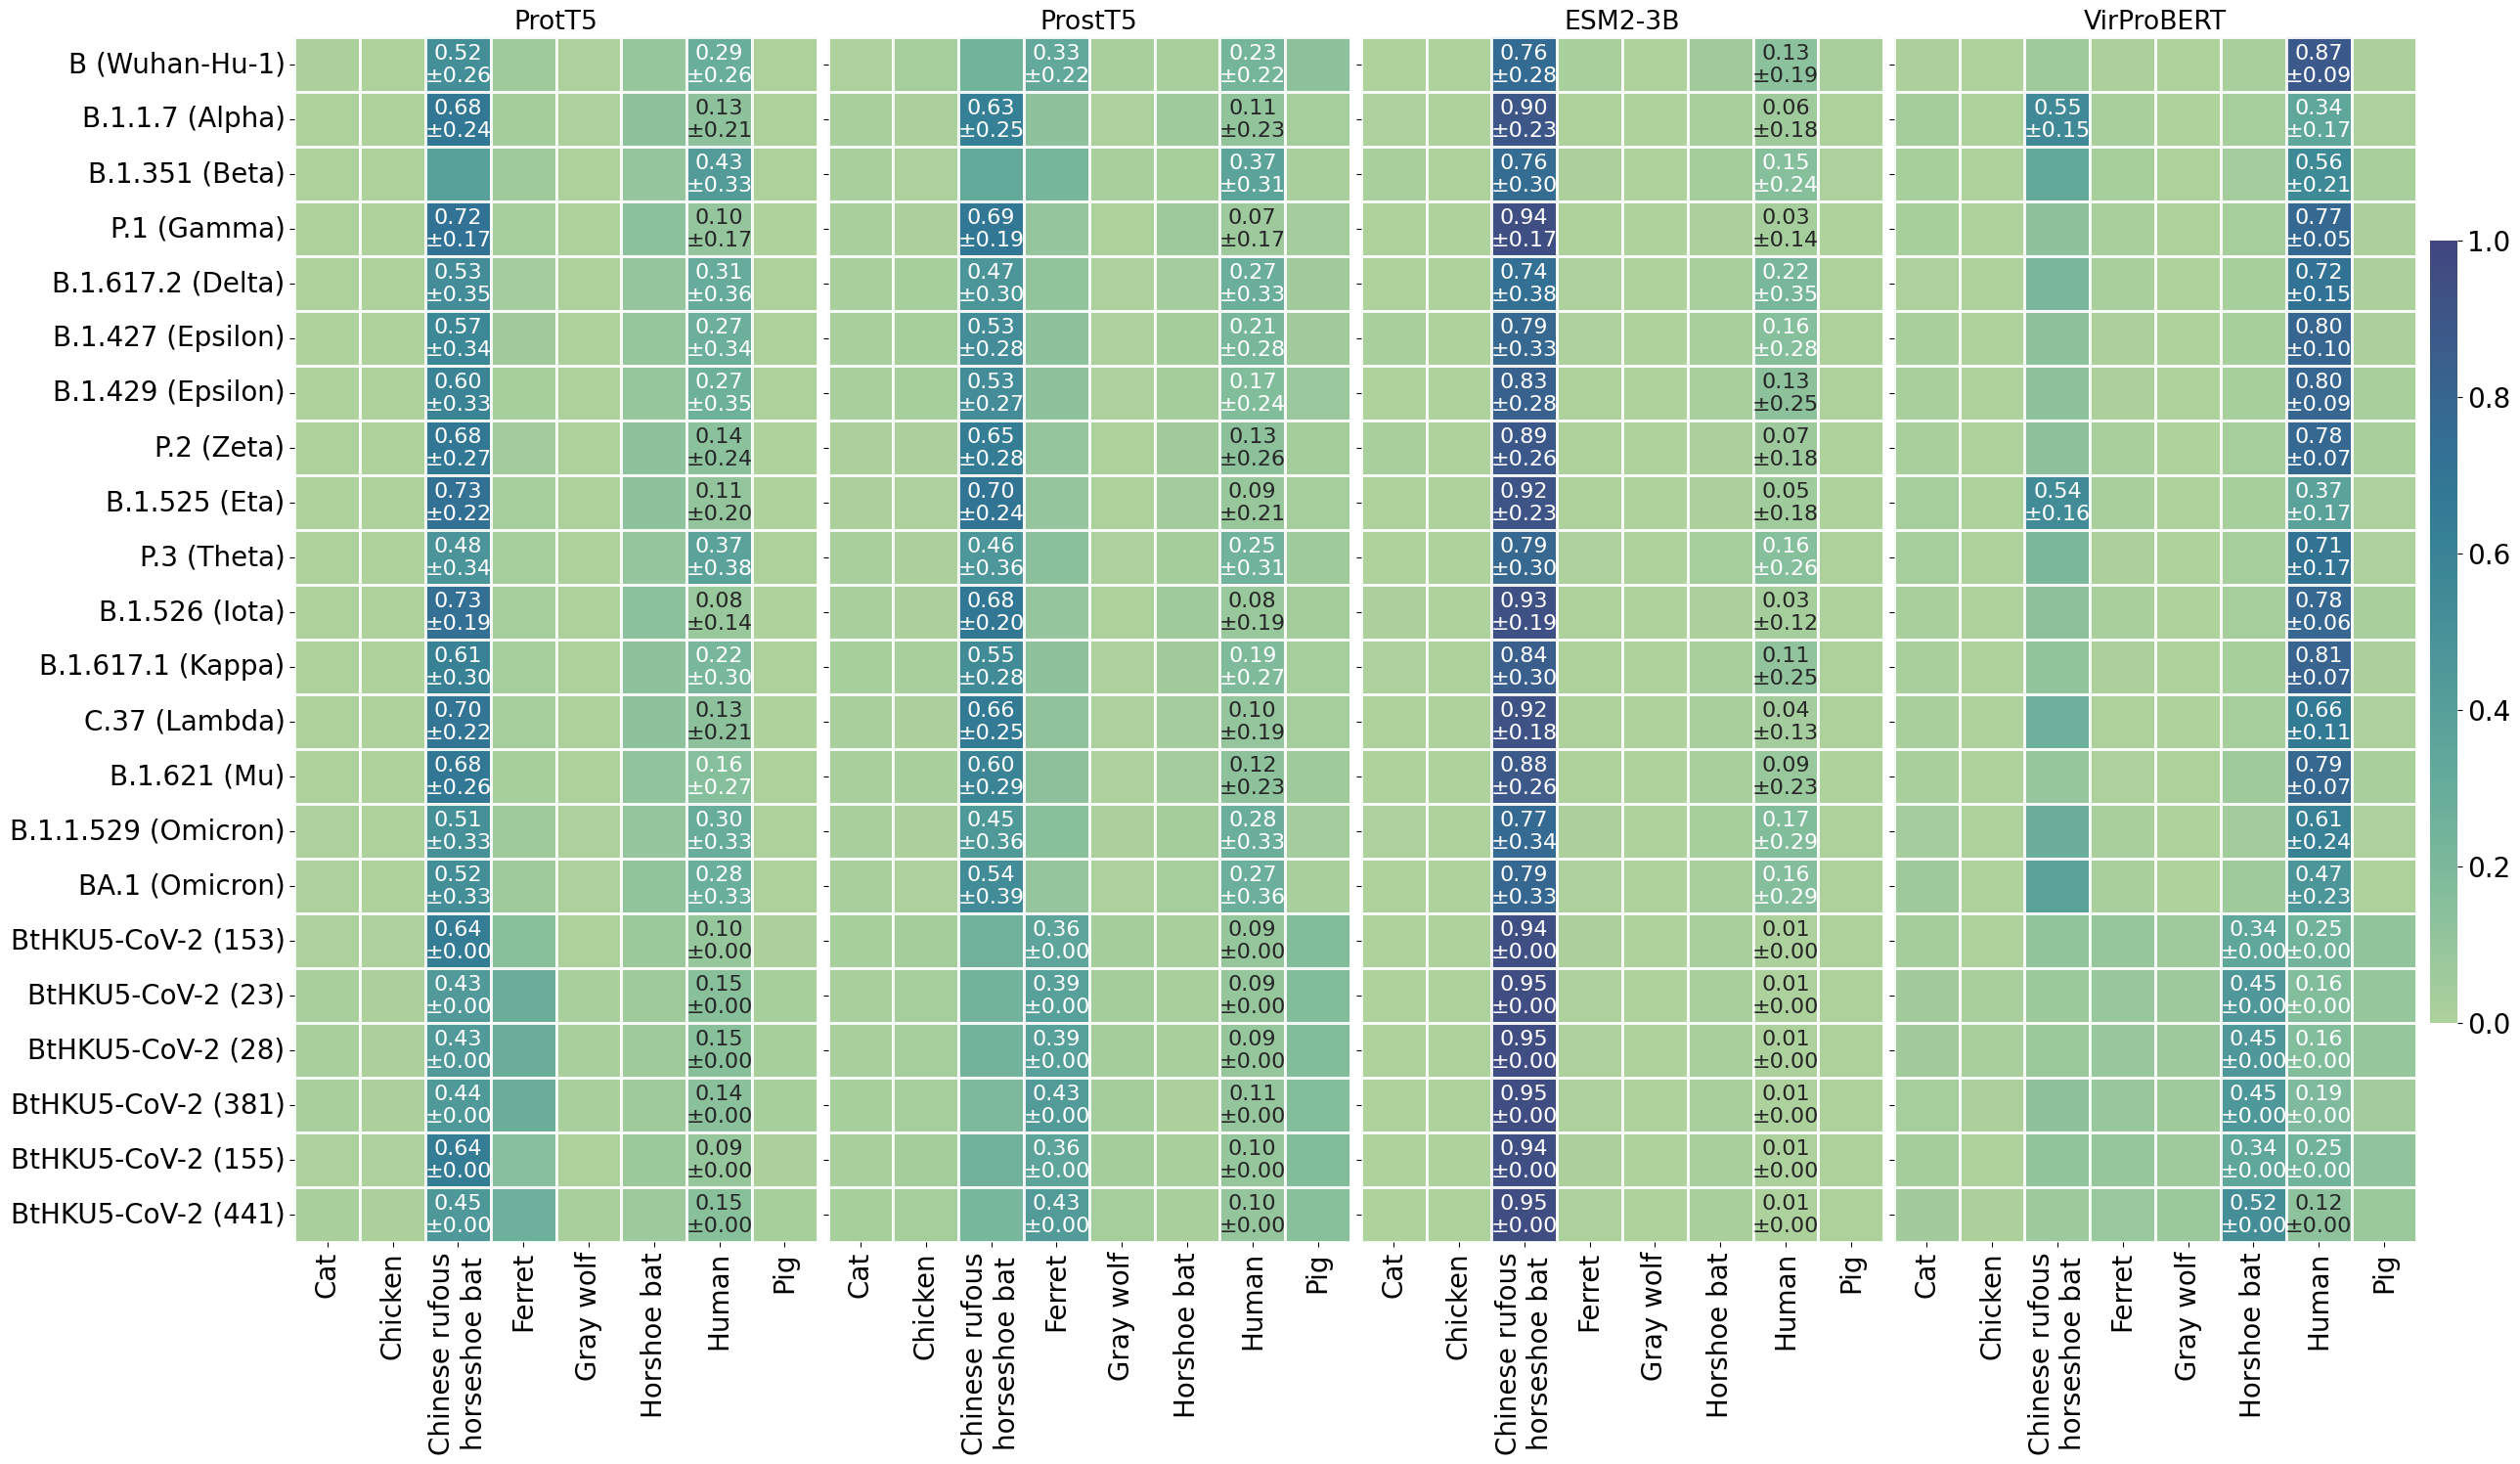

In [38]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 4, figsize=(28, 16), sharex=False, sharey=True)

cbar_ax = fig.add_axes([.905, .25, .01, .5])
for i, model in enumerate(models):
    model_df = df[df["model"] == model][["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig", "pango_who_annotation"]].set_index("pango_who_annotation")
    print(f"model = {model_df.shape}")
    heatmap_df = model_df.groupby("pango_who_annotation").agg("mean").reindex(variant_order_combined)
    model_df.rename(columns={"Chinese rufous horseshoe bat": "Chinese rufous\nhorseshoe bat"}, inplace=True)
    heatmap_df.rename(columns={"Chinese rufous horseshoe bat": "Chinese rufous\nhorseshoe bat"}, inplace=True)
    sns.heatmap(heatmap_df, ax=axs[i], linewidth=2,
                annot=get_annotation_df(heatmap_df, model_df), fmt="",
                vmin=0, vmax=1,
                cbar=i == 0, 
                cbar_ax=None if i != 0 else cbar_ax,
                cmap="crest", alpha=.9)
    axs[i].set_title(model)
    axs[i].set(xlabel="", ylabel="")
plt.subplots_adjust(wspace=0.02)
plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/sarscov2_variants_bthku5cov2_uniref90.pdf"), bbox_inches="tight")
plt.show()

In [19]:
df

,accession_id,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,y_true,pangolin_lineage,geo_location,seq_length,model,Human_pred_diff,who_variant,designation,first_designation_date,location,pango_who_annotation
0,UDW43218.1,0.006330,1.050447e-02,0.006680,0.032874,0.005100,0.019163,0.909526,0.009823,Human,C.37,USA: Texas,1266.0,ProtT5,0.877108,Lambda,VOI,6/14/2021,Peru,C.37 (Lambda)
1,UJZ71565.1,0.008074,2.483119e-07,0.000002,0.911808,0.033276,0.006743,0.028032,0.012065,Human,B.1.1.529,USA,1273.0,ProtT5,-0.004386,Omicron,VOC,11/26/2021,South Africa,B.1.1.529 (Omicron)
2,UES70215.1,0.003342,1.227013e-03,0.795080,0.015439,0.004009,0.139110,0.039315,0.002477,Human,B.1.526,USA,1273.0,ProtT5,0.006897,Iota,VOI,3/24/2021,USA,B.1.526 (Iota)
3,QSE06394.1,0.003247,1.127909e-03,0.806335,0.014812,0.003732,0.130946,0.037447,0.002354,Human,P.2,USA: California,1273.0,ProtT5,0.005029,Zeta,VOI,3/17/2021,Brazil,P.2 (Zeta)
4,QTN76737.1,0.003458,1.174976e-03,0.801658,0.015148,0.003921,0.133582,0.038618,0.002440,Human,P.2,USA: New Jersey,1273.0,ProtT5,0.006200,Zeta,VOI,3/17/2021,Brazil,P.2 (Zeta)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,QUI11057.1,0.033002,3.407135e-03,0.076918,0.020166,0.010857,0.016620,0.824890,0.014139,Human,B.1.526,NaN,NaN,ESM3,NaN,Iota,VOI,3/24/2021,USA,B.1.526 (Iota)
6100,QVE76837.1,0.002282,6.879618e-04,0.766168,0.007731,0.002871,0.182816,0.027462,0.009982,Human,B.1.525,NaN,NaN,ESM3,NaN,Eta,VOI,3/17/2021,Nigeria,B.1.525 (Eta)
6101,QTS06228.1,0.002649,8.060397e-04,0.774727,0.008059,0.003375,0.171108,0.028715,0.010560,Human,B.1.427,NaN,NaN,ESM3,NaN,Epsilon,VOI,3/5/2021,USA,B.1.427 (Epsilon)
6102,UIT31286.1,0.008682,3.081843e-04,0.506420,0.020655,0.019005,0.082999,0.341344,0.020586,Human,P.2,NaN,NaN,ESM3,NaN,Zeta,VOI,3/17/2021,Brazil,P.2 (Zeta)


In [20]:
sub_df = df[["pango_who_annotation", "model", "Chinese rufous horseshoe bat", "Human"]]
sub_df = sub_df.set_index(["pango_who_annotation", "model"]).stack().reset_index().rename(columns={"level_2": "class", 0: "probability"})
sub_df

,pango_who_annotation,model,class,probability
0,C.37 (Lambda),ProtT5,Chinese rufous horseshoe bat,0.006680
1,C.37 (Lambda),ProtT5,Human,0.909526
2,B.1.1.529 (Omicron),ProtT5,Chinese rufous horseshoe bat,0.000002
3,B.1.1.529 (Omicron),ProtT5,Human,0.028032
4,B.1.526 (Iota),ProtT5,Chinese rufous horseshoe bat,0.795080
...,...,...,...,...
12203,B.1.427 (Epsilon),ESM3,Human,0.028715
12204,P.2 (Zeta),ESM3,Chinese rufous horseshoe bat,0.506420
12205,P.2 (Zeta),ESM3,Human,0.341344
12206,BA.1 (Omicron),ESM3,Chinese rufous horseshoe bat,0.770325


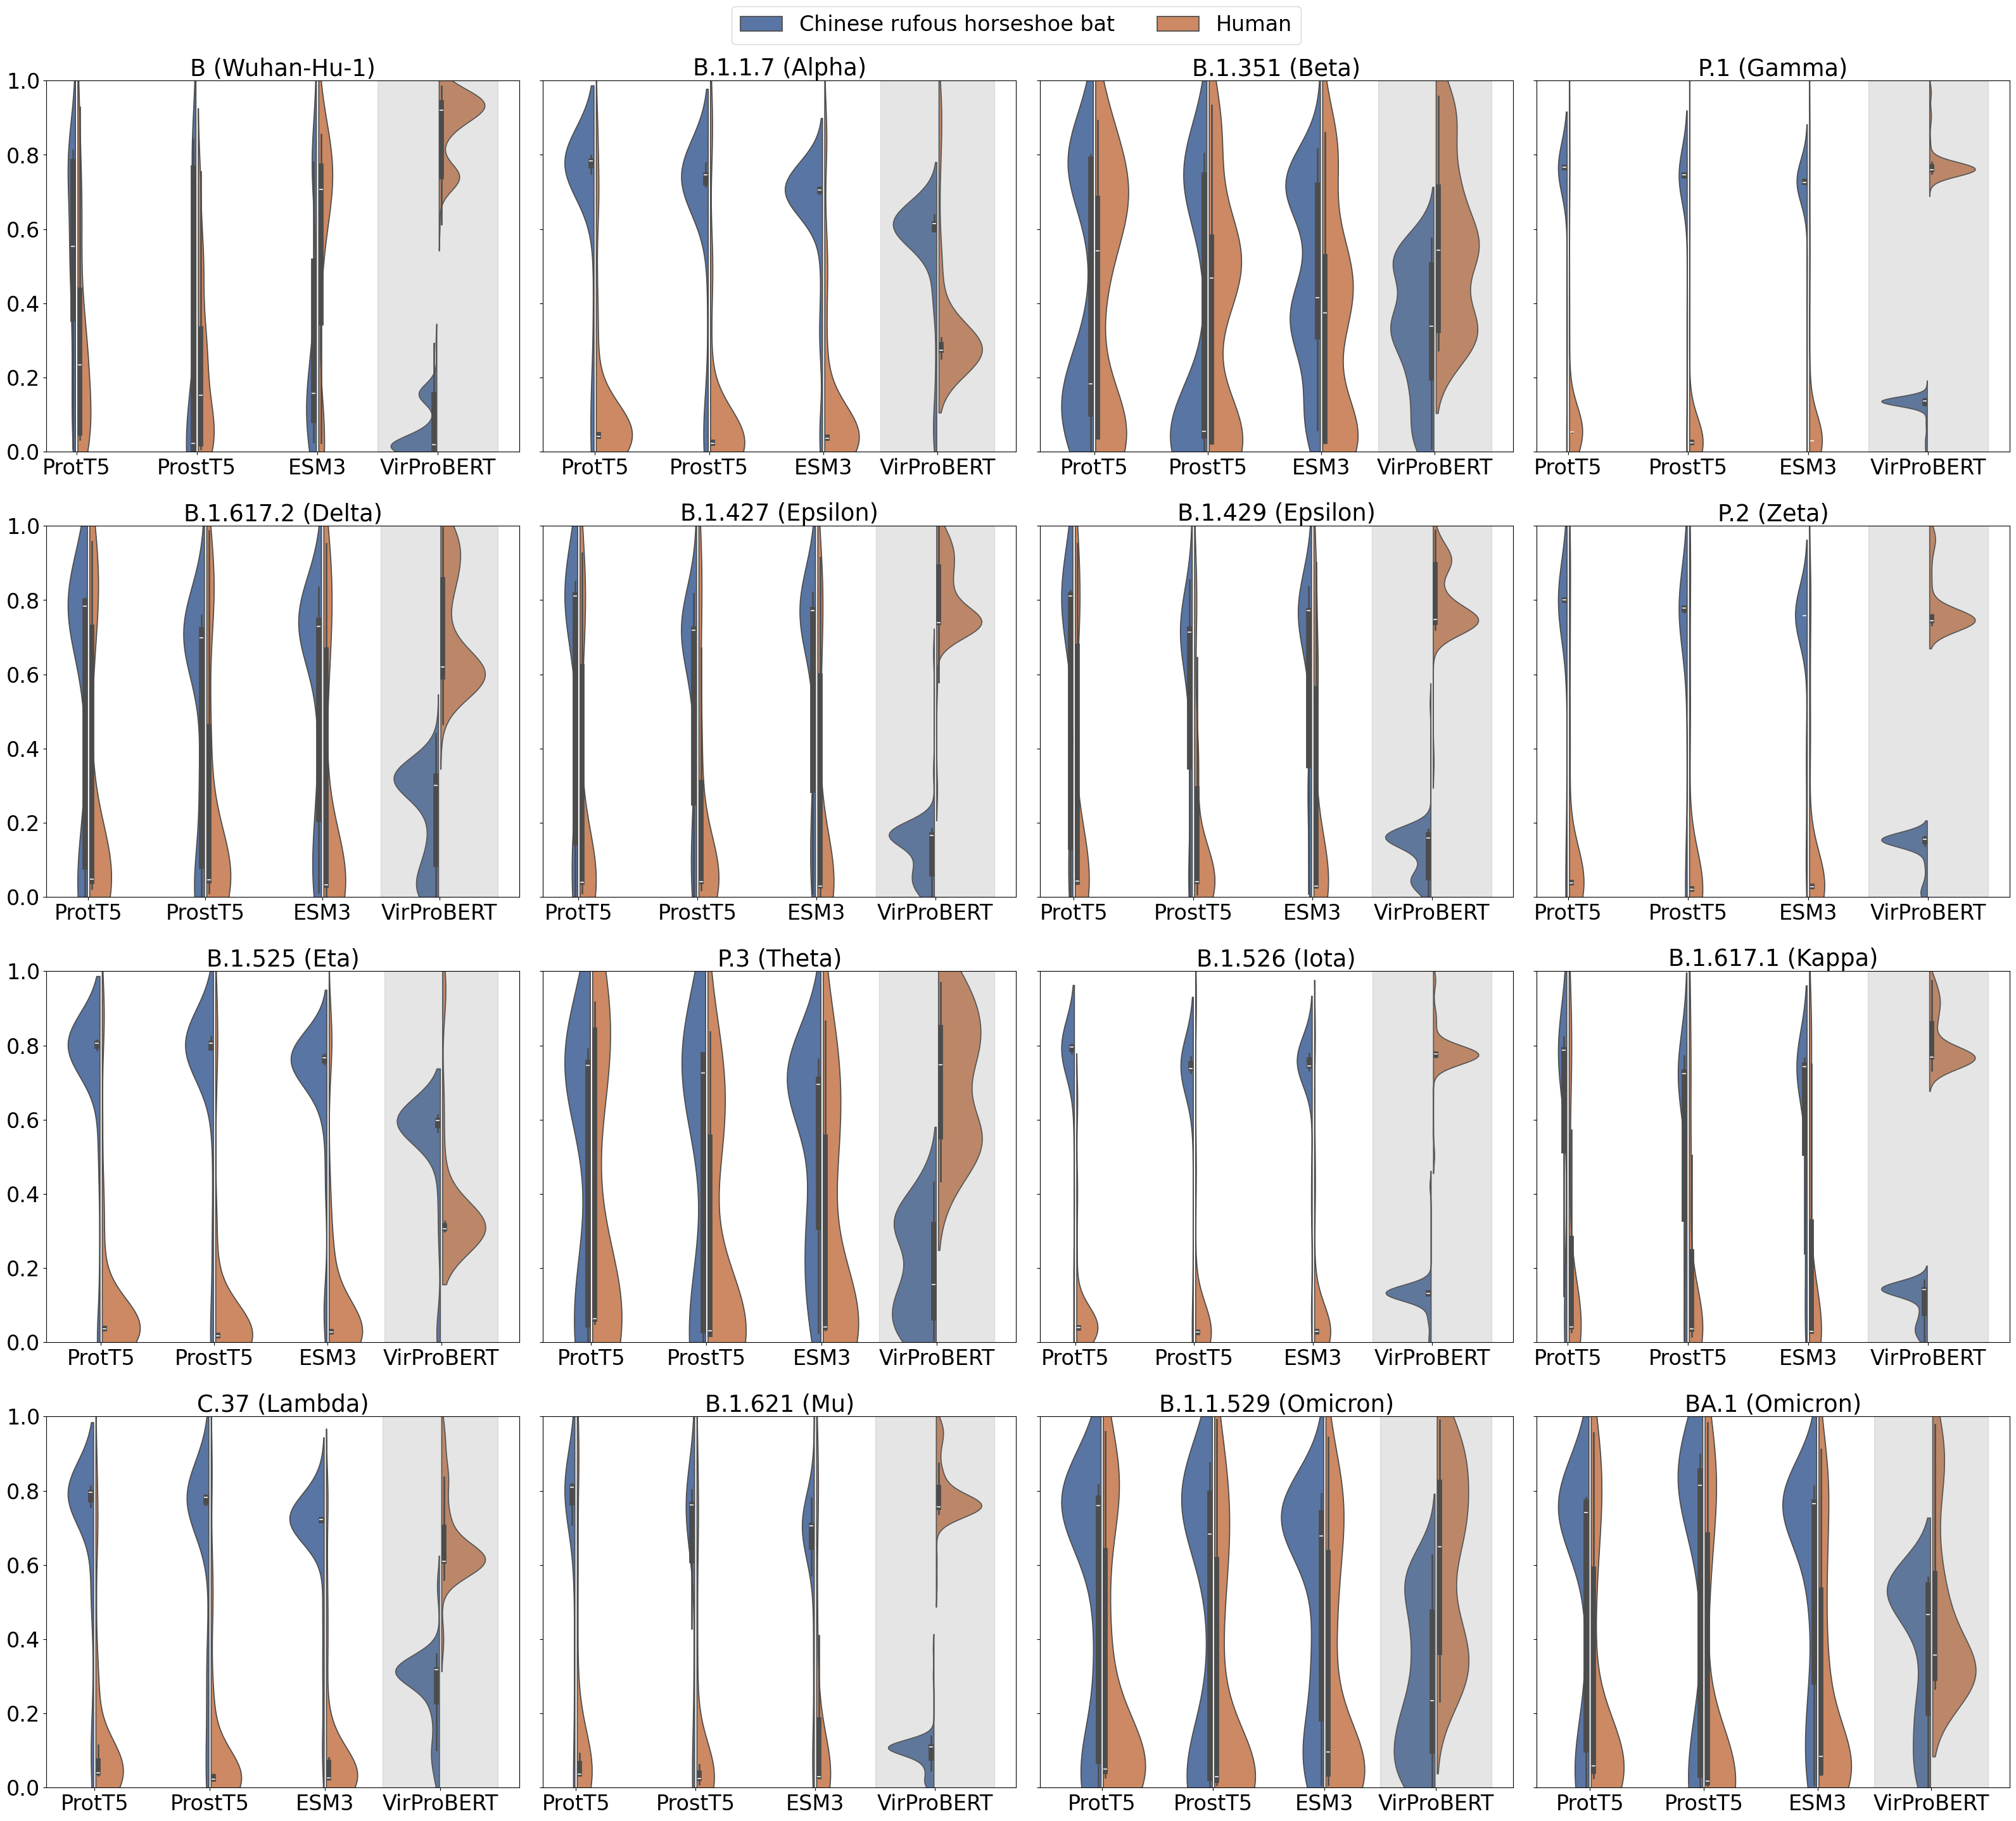

In [21]:
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(4, 4, figsize=(40, 35), sharex=False, sharey=True)

i = 0
legend_ax = None
virprobert_index = len(models) - 1
for ax_row in axs:
    for ax in ax_row:
        if i == 1:
            legend_ax = ax
        variant = variant_order[i]
        plot_df = sub_df[sub_df["pango_who_annotation"] == variant][["model", "class", "probability"]]
        sns.violinplot(plot_df, x="model", y="probability", hue="class", ax=ax, 
                       split=True, gap=.05, fill=True, palette="deep", order=models,
                      legend=False if i != 1 else True)
        ax.set_title(variant)
        ax.set(xlabel="", ylabel="")
        i += 1
        ax.axvspan(virprobert_index - .5, virprobert_index + .5, color="gray", alpha=0.2)
        ax.set_ylim(0, 1)

for ax in axs.flat:
    ## check if something was plotted 
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted in the axes obj
        
sns.move_legend(
    legend_ax, "lower center",
    bbox_to_anchor=(1, 1.07), ncol=2, title=None, frameon=True, fontsize=24
)
plt.subplots_adjust(wspace=0.05)
plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/sarscov2_variants_uniref90_crhb_human_violinplot.pdf"), bbox_inches="tight")
plt.show()